## Projection and adjoint

This is a brief tutorial that explains how to perform the two fundamental operations of tomography, the projection and adjoint. It uses the `SAXSProjector` class, which is a relatively simple projector that uses only CPU resources.
The simulated data used in the rendered version of this tutorial can be obtained using, e.g., ``wget`` with
```shell
wget https://zenodo.org/records/7326784/files/saxstt_dataset_M.h5
```
It's recommended that you read the section *Reconstruct and Visualize* first, which goes over basics of data loading and reconstruction, whereas this tutorial goes into the details of the projection operations that make up the reconstruction.


In [1]:
import logging
import h5py
import numpy as np
import colorcet
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
from IPython.display import display
from mumott.data_handling import DataContainer
from mumott.methods.basis_sets import SphericalHarmonics
from mumott.methods.projectors import SAXSProjector
from mumott.methods.residual_calculators import GradientResidualCalculator

INFO:Setting the number of threads to 8
INFO:Setting numba log level to WARNING.


### Loading data

For details on these steps, see the tutorial "Reconstruct and visualize". We will also be using the `data_container` of input data from the `DataContainer` instance.

In [2]:
data_container = DataContainer('saxstt_dataset_M.h5')
projections = data_container.projections

INFO:Rotation matrix generated from inner and outer angles, along with inner and outer rotation axis vectors. Rotation and tilt angles assumed to be in radians.


mumott/data_handling/data_container.py:227: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
mumott/data_handling/data_container.py:236: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
mumott/data_handling/data_container.py:268: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
mumott/data_handling/data_container.py:278: DeprecationWarning: Entry name offset_k is deprecated. Use k_offset instead.
  _deprecated_key_warning('offset_k')


INFO:No sample geometry information was found. Default mumott geometry assumed.
INFO:No detector geometry information was found. Default mumott geometry assumed.


### Looking at the simulated data

We're going to compare projections calculated from a simulated model to simulated projections with noise.

We will be using a `SAXSProjector` object for our computations. We suppress some of the warnings that it outputs which are not useful to us.

In [3]:
projector = SAXSProjector(data_container.geometry)
logger = logging.getLogger('mumott.methods.projectors.saxs_projector')
logger.setLevel(logging.CRITICAL)

The model coefficients need to be loaded directly using `h5py`. The last index runs over the spherical harmonic coefficients.

In [4]:
with h5py.File('saxstt_dataset_M.h5') as file:
    model = np.copy(file['model/coefficients'])
print(model.shape)

(50, 50, 50, 91)


We will use the `projection_matrix` to do the necessary mapping into detector segment space. This matrix contains the necessary coefficient to map spherical harmonic coefficients to line integrals on the sphere, which correspond to detector segments. The shape of `sph_matrices` corresponds to (projection number, segment number, coefficient number).

In [5]:
basis_set = SphericalHarmonics(ell_max=12)
residual_calculator = GradientResidualCalculator(data_container, basis_set, projector)
sph_matrices = basis_set.projection_matrix
display(sph_matrices.shape)

(417, 8, 91)

To calculate the projections, we use the coefficients in `model` as our input. `model` already has the necessary shape and the required `dtype` of `float64`. We select an index somewhat at random.

It is generally more efficient to first project the coefficients, and then map to the detector segment space, than to compute a matrix product over the entire volume. This is especially true when projecting in several directions sequentially.

In [6]:
index = 56
projection = projector.forward(field=model, indices=np.array((index,)))
projection = projection @ sph_matrices[index].T

We now plot a segment of the projection we got from the file, the projection we just calculated, and their absolute difference.

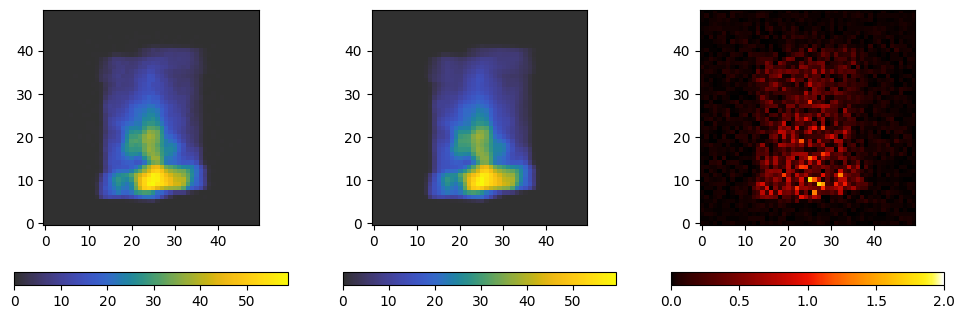

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

kwargs = dict(origin='lower', cmap='cet_gouldian')

d = axes[0].imshow(projections[index].data[..., 0].T, **kwargs)
plt.colorbar(d, ax=axes[0], orientation='horizontal')

p = axes[1].imshow(projection[..., 0].T, **kwargs)
plt.colorbar(p, ax=axes[1], orientation='horizontal')

diff = axes[2].imshow(abs(projections[index].data[..., 0].T - projection[0, ..., 0].T), origin='lower', cmap='cet_fire', vmax=2)
plt.colorbar(diff, ax=axes[2], orientation='horizontal')

### The adjoint

The adjoint is essentially the partial derivative of the volume with respect to the projection. It's also called a back-projection, and it is essential to solving for a volume given a set of projections.

In [8]:
adjoint = projector.adjoint(projections=projection, indices=np.array((index,)))

We plot a slice in the middle of the adjoint through the `xy`-plane.

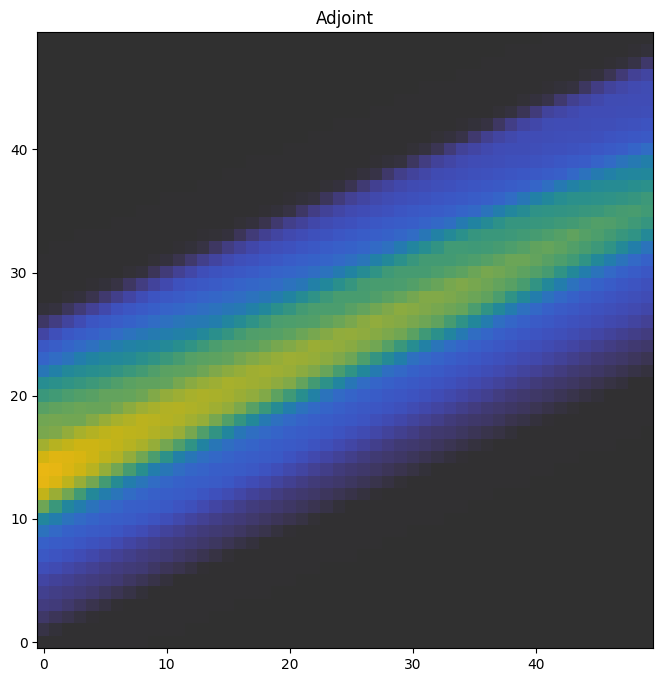

In [9]:
f, ax = plt.subplots(1, figsize=(8,8))

a0 = ax.imshow(adjoint[:, :, 25, 0].T, origin='lower', cmap='cet_gouldian', vmax=40)
ax.set_title('Adjoint')
plt.colorbar(a0, ax=axes)


This concludes the tutorial.